# DCGAN to generate MNIST images
We will follow the Machine Learning Project Checklist from the book "Hands-On Machine Learning with Scikit-Learn and TensorFLow".  

It contains eight steps (we interpret these as advice, not rules):
1. Frame the problem and look at the big picture  
2. Get the data  
3. Explore the data to gain insights  
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms  
5. Explore many different models and short-list the best ones (we will only include our final model)
6. Fine-tune your models and combine them into a great solution (Step 5 will present our fine-tuned model)
7. Present your solution  
8. Launch, monitor and maintain your system (not applicable to us)



In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import os
import datetime
import pytz # For time stuff

%matplotlib inline

# to make this notebook's output stable across runs (from lab2)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
print(f"TensorFlow version: {tf.__version__}")
print(f"tf.Keras version: {tf.keras.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pytz version: {pytz.__version__}")
print(f"Numpy version: {np.__version__}")

C:\Users\Megatron\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.12.0
tf.Keras version: 2.1.6-tf
Matplotlib version: 2.2.2
Pytz version: 2018.4
Numpy version: 1.14.3


## 1. Frame the Problem and Look at the Big Picture

**How is performance measured:** The DCGAN's performance is measured by us (and our teacher) by interpreting the overall quality of the resulting image. Basically, the performance is good if we can look at a generated MNIST image and think that a human have written it.  

## 2. Get the Data
Fetch the data

In [2]:
mnist = tf.keras.datasets.mnist
(train_imgs, train_labels), (_, _) = mnist.load_data()

Verify the data's shape

In [11]:
print(f"Train images shape: {train_imgs.shape}")
print(f"Train images data type: {train_imgs.dtype}")

Train images shape: (60000, 28, 28)
Train images data type: uint8


## 3. Explore the data to gain insights  
Below, we can see five images from each MNIST class

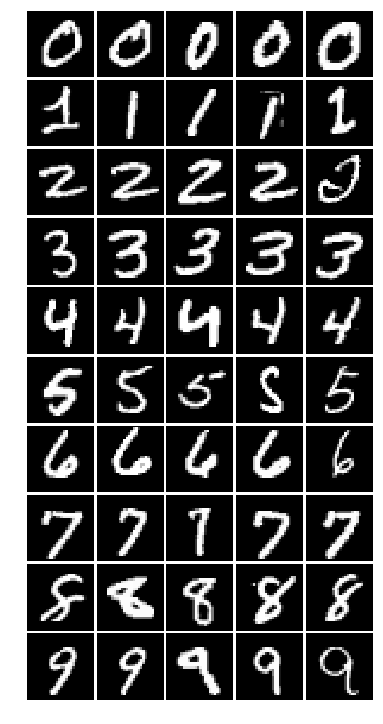

In [12]:
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.4, bottom=0.1, right=0.8, top=0.9, wspace=0.05, hspace=0.01)

currentClass = 0 # Decides which MNIST class to print

for i in range(1, 51):
    imageIdx = np.nonzero(train_labels == currentClass)[0] # This finds the indices of specific classes
    imgToPrint = imageIdx[i-1]
    fig.add_subplot(10,5,i).imshow(train_imgs[imgToPrint,:,:], cmap="gray")
    plt.axis("off")
    
    if i % 5 == 0:
        currentClass += 1 # Go to next class

Examine the distribution of classes in the MNIST dataset. 

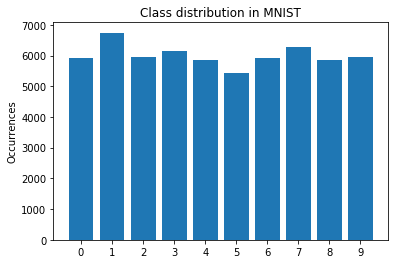

In [13]:
# Gather the count for each class, 0-9
classCount = []
for i in range(10):
    classCount.append(len(np.nonzero(train_labels == i)[0]))

# Display a bar chart with the counts
plt.bar(np.arange(10), classCount)
plt.xticks(np.arange(10), [0,1,2,3,4,5,6,7,8,9])
plt.ylabel("Occurrences")
plt.title("Class distribution in MNIST")

plt.show()

## 4. Prepare the data

The MNIST dataset is already clean and the classes are fairly evenly distributed so there is not much preparation to be done. The one thing we do is feature scaling by zero centering and normalizing the data.

In [36]:
train_imgs = (train_imgs / 127.5) - 1 # Pixel scaling. Resulting pixel value in range [-1, 1]   
train_imgs = np.expand_dims(train_imgs, 3) # Add channel axis
#print(train_imgs.shape)

Define helper functions for the model

In [43]:
def createDirs():
    """
    Creates a directory named with a timestamp which containing three directories.
        1. generatedImages
        2. losses
        3. weights
        
    Returns: image path, loss path, weight path
    """
    
    # Get a timestamp which is used to name the top-level directory
    timestamp = str(datetime.datetime.now(tz=pytz.FixedOffset(60))) # Needed 60 min offset
    timestamp = timestamp.replace(" ", "_").replace(":", ".")[:19] # Remove some unwanted things from the timestamp
    
    curDir = os.path.curdir
    basePath = os.path.join(curDir, "runs")
    topPath = os.path.join(basePath, timestamp)
    imgPath = os.path.join(topPath, "generatedImages")
    lossPath = os.path.join(topPath, "losses")
    weightPath = os.path.join(topPath, "weights")
    
    # Create directories
    os.makedirs(basePath, exist_ok=True) # If it already exists, its fine
    os.makedirs(topPath)
    os.makedirs(imgPath)
    os.makedirs(lossPath)
    os.makedirs(weightPath)
    
    return imgPath, lossPath, weightPath

In [31]:
def plotLoss(d_loss, g_loss, path, save=True):
    """
    Plots the discriminators and generators losses and 
    saves the image to the parameter path if save is True
    """
    
    plt.figure(figsize=(7,7))
    plt.plot(d_loss)
    plt.plot(g_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Mini-batch')
    plt.legend(['Discriminator', 'Generator'], loc='upper left')
    
    if (save):
        plt.savefig(path, bbox_inches="tight")
    
    plt.show()

In [30]:
def plotGeneratedImages(imgs, path, save=True):
    """
    Plots a set of images as one plot. Save the plot to path if save is true
    """
    fig = plt.figure(figsize=(25,25))
    plt.subplots_adjust(left=0.3, bottom=0.5, right=0.6, top=0.8, wspace=0.05, hspace=0.05)
    maxNumPics = min(batch_size, 26) # Prevents an error if we use a batch size smaller than 26
    for i in range(1, maxNumPics):
        fig.add_subplot(5,5,i).imshow(np.squeeze(test_imgs, 3)[i,:,:], cmap="gray") # Squeeze to remove channel axis
        plt.axis("off")
        
    # Save some generated images each epoch in order to see improvement as training progresses
    plt.savefig(path, bbox_inches="tight")

## 5. The DCGAN-model  
We start by defining functions for creating a generator and a discriminator

In [49]:
def buildGenerator():
    """
    Constructs the generator part of the DCGAN
    """

    model = tf.keras.Sequential()
    model.add(layers.Dense(units=7*7*32,input_shape=(1,1,100),
                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02), use_bias=False))
    model.add(layers.BatchNormalization(scale=False, center=False))

    model.add(layers.ReLU())
    model.add(layers.Reshape(target_shape=(7,7,32)))
    # Read the link below to understand output shapes of Conv2DTranspose
    # https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula
    # Output shape: (batch, new_rows, new_cols, filters)

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding="same",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02), use_bias=False))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding="same",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                     activation='tanh'))

    model.summary()

    return model

In [50]:
def buildDiscriminator():
    """
    Constructs the discriminator part of the DCGAN
    """

    model = tf.keras.Sequential()

    
    model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                            kernel_size=3, strides=2, padding="same",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02), use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(filters=32, kernel_size=3,
                            strides=2, padding="same",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02), use_bias=False))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.LeakyReLU(alpha=0.2)) # We should be able to remove this

    model.add(layers.Flatten()) 
    model.add(layers.Dense(units=7*7*32 ,
                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02), use_bias=False))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(units=1, 
                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                           activation=tf.nn.sigmoid))

    model.summary()

    return model

Set necessary parameters and instantiate the generator and discriminator. 

In [51]:
# Set parameters
shape = (28, 28, 1) # Shape of MNIST-data
batch_size = 32
optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

# Build the models
generator = buildGenerator()
discriminator = buildDiscriminator()

combined = tf.keras.Sequential()
combined.add(generator)
combined.add(discriminator)

# Compile the models
discriminator.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"])

combined.compile(
        optimizer=optimizer,
        loss="binary_crossentropy")

# Set up directories and paths used to save images, loss plots and saved weights
imgPath, lossPath, weightPath = createDirs()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1, 1, 1568)        156800    
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 1, 1568)        3136      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1, 1, 1568)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        51200     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 14, 14, 64)        0         
__________

Train the model

In [52]:
# Create variables for holding the losses
d_losses = []
g_losses = []
cumulative_d_loss = 0
cumulative_g_loss = 0

# Generate a noise which is used for predicting after each epoch, allows us to visually track the generators progress
test_noise = np.random.uniform(low=-1, high=1, size=(batch_size, 1, 1, 100))

# Create progress bar for training
progbar = tf.keras.utils.Progbar(target=math.floor(train_imgs.shape[0] / batch_size))

num_epochs = 50
for epoch in range(num_epochs):
    
    # Reset cumulative losses between epochs
    cumulative_d_loss = 0
    cumulative_g_loss = 0
    
    batches = math.floor(train_imgs.shape[0] / batch_size)
    for batch in range(batches):
        discriminator.trainable = True

        # Create smooth labels instead of binary labels, improves performance
        fake_labels = np.random.uniform(low=0, high=0.3, size=(batch_size,))
        real_labels = np.random.uniform(low=0.7, high=1.2, size=(batch_size,))

        # Generate new noise each mini-batch and generate images from the noise
        noise = np.random.uniform(low=-1, high=1, size=(batch_size, 1, 1, 100))
        fake_imgs = generator.predict_on_batch(noise)

        # Extract a of training images. 
        # Note that the discriminator is trained on 2 batches. We tried half-batches but it performed worse
        fromIdx = batch * batch_size
        toIdx = (batch * batch_size) + batch_size
        real_imgs = train_imgs[fromIdx:toIdx, :, :] 

        # train_on_batch performs a single gradient update on a single batch of data
        d_real_loss = discriminator.train_on_batch(real_imgs, real_labels) # Train on real imgs.
        d_fake_loss = discriminator.train_on_batch(fake_imgs, fake_labels) # Train on fake imgs.
        d_total_loss = np.add(d_real_loss[0], d_fake_loss[0]) / 2 # Index zero is the loss. Index 1 is accuracy
        cumulative_d_loss += d_total_loss

        # Discriminator not trainable right now
        # Input noise -> G(noise) -> 28x28x1 fake_img
        # Fake_img goes into the discriminator with "true" label
        # The gradient will be updated based on how well the discriminator 
        #  can determine if it is a fake or real image
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, real_labels) 
        cumulative_g_loss += g_loss

        progbar.update(batch)
    #### END OF BATCH-LOOP ####
    
    # Print losses and add mean losses to lists which are used for plotting later on
    print(f"Loss after epoch {epoch}:\n\tGenerator loss: {cumulative_g_loss/batches}\n\tDiscriminator loss: {cumulative_d_loss/batches}")
    d_losses.append(cumulative_d_loss/batches)
    g_losses.append(cumulative_g_loss/batches)

    # Generate a batch of images from the same noise after each epoch in order to track the progress
    test_imgs = generator.predict_on_batch(test_noise) # Generates batch_size number of images

    # Plot a grid of generated images after each epoch
    plotGeneratedImages(test_imgs, os.path.join(imgPath, f"epoch{epoch}")
    
    # Plot losses after each epoch
    plotLoss(d_losses, g_losses, os.path.join(lossPath, f"epoch{epoch}"))

    # Save the model's weights every Xth epochs
    if (epoch % 15 == 0):
        generator.save_weights(os.path.join(weightPath, "generator.h5"))
        discriminator.save_weights(os.path.join(weightPath, "discriminator.h5"))
        combined.save_weights(os.path.join(weightPath, "combined.h5"))

#### END OF EPOCHS ####
    
# Save FINAL models when all epochs are done 
generator.save_weights(os.path.join(weightPath, "FINAL-generator.h5"))
discriminator.save_weights(os.path.join(weightPath, "FINAL-discriminator.h5"))
combined.save_weights(os.path.join(weightPath, "FINAL-combined.h5"))  

InternalError: Blas GEMM launch failed : a.shape=(32, 100), b.shape=(100, 1568), m=32, n=1568, k=100
	 [[{{node dense_6/Tensordot/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_6/Tensordot/Reshape, dense_6/Tensordot/ReadVariableOp)]]
	 [[{{node conv2d_transpose_5/Tanh/_155}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_189_conv2d_transpose_5/Tanh", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

### WARNING:tensorflow:Discrepancy?
During training, we received "WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?"

Here we check if it matters or not it matters as it seems to be some confusion about it:  
https://github.com/keras-team/keras/issues/4471  
https://github.com/tensorflow/tensorflow/issues/22012  
https://github.com/keras-team/keras/issues/8585  

In [55]:
generator = buildGenerator()
discriminator = buildDiscriminator()

combined = tf.keras.Sequential()
combined.add(generator)
combined.add(discriminator)

optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
# Compile the models
discriminator.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"])

combined.compile(
        optimizer=optimizer,
        loss="binary_crossentropy")

discriminator.trainable = False
discriminator.summary()
discriminator.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1, 1, 1568)        156800    
_________________________________________________________________
batch_normalization_16 (Batc (None, 1, 1, 1568)        3136      
_________________________________________________________________
re_lu_8 (ReLU)               (None, 1, 1, 1568)        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 64)        51200     
_________________________________________________________________
batch_normalization_17 (Batc (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 14, 14, 64)        0         
__________

### Load weights and make some predictions  
Edit the variable "whichRun" in order to choose which weights to load.  
There are two variables named "path". One is for non-final weights and one is for the final-weights.

In [53]:
# Since we can't save the entire model (due to some Keras fault) we will save the weights, re-buiild the model
# and apply the saved weights to our model. 

# Build the models
generator = buildGenerator()
discriminator = buildDiscriminator()

combined = tf.keras.Sequential()
combined.add(generator)
combined.add(discriminator)

optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
# Compile the models
discriminator.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"])

combined.compile(
        optimizer=optimizer,
        loss="binary_crossentropy")

whichRun = "2018-12-20_15.06.44" # REPLACE THIS WITH THE RUN YOU WANT TO LOAD
path = os.path.join(os.curdir, "runs", whichRun, "weights", "generator.h5")          # If you want non-final weight
#path = os.path.join(os.curdir, "runs", whichRun, "weights", "FINAL-generator.h5")   # If you want final weight
generator.load_weights(path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1, 1, 1568)        156800    
_________________________________________________________________
batch_normalization_12 (Batc (None, 1, 1, 1568)        3136      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 1, 1, 1568)        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        51200     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 14, 14, 64)        0         
__________

Rerun the cell below to produce different predictions

In [ ]:
test_noise = np.random.uniform(low=-1, high=1, size=(32, 1, 1, 100))
imgs = generator.predict_on_batch(test_noise) 
plotGeneratedImages(imgs, None, save=False)

## 7. Present your solution 

Document what we have done  
Create a nice presentation  
Explain why our solution acheives the business objective  
Present interesting points we noticed along the way  
Describe what worked and what didn't  
List our assumptions and the model's limitations  


Here is some code that generates gifs from the generated images and losses of each run. The gifs are saved in the folder representing each run

In [27]:
# Gif-generating code from: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
import imageio
import os
import sys
import re

# Type this in the terminal to run: python createGif.py
# Will create a gif for each folder of .pngs in the folder /generatedImages

##############
# Source: https://stackoverflow.com/a/5967539
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]
##############

def gifItUp():
    
    dirs = os.listdir("runs")
    dirs.remove(".ipynb_checkpoints")
    
    for dir_ in dirs:
        path = os.path.abspath(os.path.join(os.path.curdir, "runs", dir_))
        if (os.path.isdir(path)): 
            
            # Loop through each directory (which is a separate run) and create a gif of all 
            # .pngs from that directory (generatedImages & losses)
            dir_with_imgs_losses_weights = os.path.join("runs", dir_)

            pictures = os.listdir(os.path.join(dir_with_imgs_losses_weights, "generatedImages"))
            losses = os.listdir(os.path.join(dir_with_imgs_losses_weights, "losses"))

            if (len(pictures) != 0):
                # Pre-processing step. Sometimes a ".ipyn_checkpoint appears and we also want the files sorted
                is_not_png = lambda x: ".png" in x
                pictures = list(filter(is_not_png, pictures))
                pictures.sort(key=natural_keys)

                images = []
                for pic in pictures:
                    images.append(imageio.imread(os.path.join(dir_with_imgs_losses_weights, "generatedImages", pic)))
                imageio.mimsave(os.path.join("runs", dir_, "generatedImages"+".gif"), images)

            if (len(losses) != 0):    
                losses = list(filter(is_not_png, losses))
                losses.sort(key=natural_keys)

                images = []
                for loss in losses:
                    images.append(imageio.imread(os.path.join(dir_with_imgs_losses_weights, "losses", loss)))
                imageio.mimsave(os.path.join("runs", dir_, "loss"+".gif"), images)

Run the next cell to create the gifs

In [29]:
gifItUp()

.
